# Daily Financial News for 6000+ Stocks
### Some Data Understanding an Preparation for Prediction of stockpricse by the Sentiment of Headlines
@author DHR <br>
@author BKN <br>
used Data in this Notebook: 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests'

## Requirements

In [1]:
#immport basic DataScience Modules
#!! for pip-modul-list to install @see requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#import basic topic modelling
import re
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import gensim

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#import basic visualization
from wordcloud import WordCloud, STOPWORDS
import nltk #tokenization
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#import basic api requirements
from polygon import RESTClient
import datetime
import time

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
#Load Data
data = pd.read_csv('../data/raw_analyst_ratings.csv')
#colums: id,headline,url,publisher,date,stock

## Data Understanding

No Data Cleaning

In [34]:
#first Look
print(data.columns)
data.head()

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [35]:
#statistics
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



In [20]:
data.count()

id           1407328
headline     1407328
url          1407328
publisher    1407328
date         1407328
stock        1407328
dtype: int64

In [3]:
stock = data.groupby("stock")
stock.head()

,id,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
...,...,...,...,...,...,...
1407261,1413782,China Zenix Auto International Announces Inten...,https://www.benzinga.com/news/18/06/11886479/c...,Benzinga Newsdesk,2018-06-15 09:01:12-04:00,ZX
1407262,1413783,China Zenix Auto Shares Halted News Pending,https://www.benzinga.com/news/18/06/11876679/c...,Benzinga Newsdesk,2018-06-13 16:52:35-04:00,ZX
1407263,1413784,"China Zenix Auto Q1 EPS $0.08, Made $130.123M ...",https://www.benzinga.com/news/earnings/18/05/1...,Benzinga Newsdesk,2018-05-17 06:01:41-04:00,ZX
1407264,1413785,"China Zenix Auto Reports Q4 EPS $0.03, Sales $...",https://www.benzinga.com/news/earnings/18/03/1...,Eddie Staley,2018-03-15 06:01:22-04:00,ZX


In [18]:
stock.describe()

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                                                              \
        count          mean         std        min         25%        50%   
stock                                                                       
A      1433.0  8.414222e+02  572.641862        0.0      358.00      716.0   
AA     2739.0  3.208664e+03  796.519728     1835.0     2519.50     3204.0   
AAC     162.0  4.681500e+03   46.909487     4601.0     4641.25     4681.5   
AADR      2.0  4.763500e+03    0.707107     4763.0     4763.25     4763.5   
AAL     460.0  5.005261e+03  133.349498     4765.0     4890.75     5005.5   
...       ...           ...         ...        ...         ...        ...   
ZTR      19.0  1.412033e+06    5.627314  1412024.0  1412028.50  1412033.0   
ZTS     623.0  1.412354e+06  179.988889  1412043.0  1412198.50  1412354.0   
ZU      161.0  1.412746e+06   46.620811  1412666.0  1412706.00  1412746.0   
ZUMZ    955.0  1.413304e+06  275.829053  1412827.0  1413065.50  1413304.0   
ZX       67.0  1.413815e+06   19.485037  1413782.0  1413798.50  1413815.0   

                              
              75%        max  
stock                         
A         1476.00     1834.0  
AA        3902.50     4600.0  
AAC       4721.75     4762.0  
AADR      4763.75     4764.0  
AAL       5120.25     5235.0  
...           ...        ...  
ZTR    1412037.50  1412042.0  
ZTS    1412509.50  1412665.0  
ZU     1412786.00  1412826.0  
ZUMZ   1413542.50  1413781.0  
ZX     1413831.50  1413848.0  

[6204 rows x 8 columns]

In [33]:
data['date']

0          2020-06-05 10:30:54-04:00
1          2020-06-03 10:45:20-04:00
2          2020-05-26 04:30:07-04:00
3          2020-05-22 12:45:06-04:00
4          2020-05-22 11:38:59-04:00
                     ...            
1407323          2011-08-29 00:00:00
1407324          2011-06-22 00:00:00
1407325          2011-06-21 00:00:00
1407326          2011-06-21 00:00:00
1407327          2011-05-12 00:00:00
Name: date, Length: 1407328, dtype: object

### Data Visualization

<AxesSubplot:>

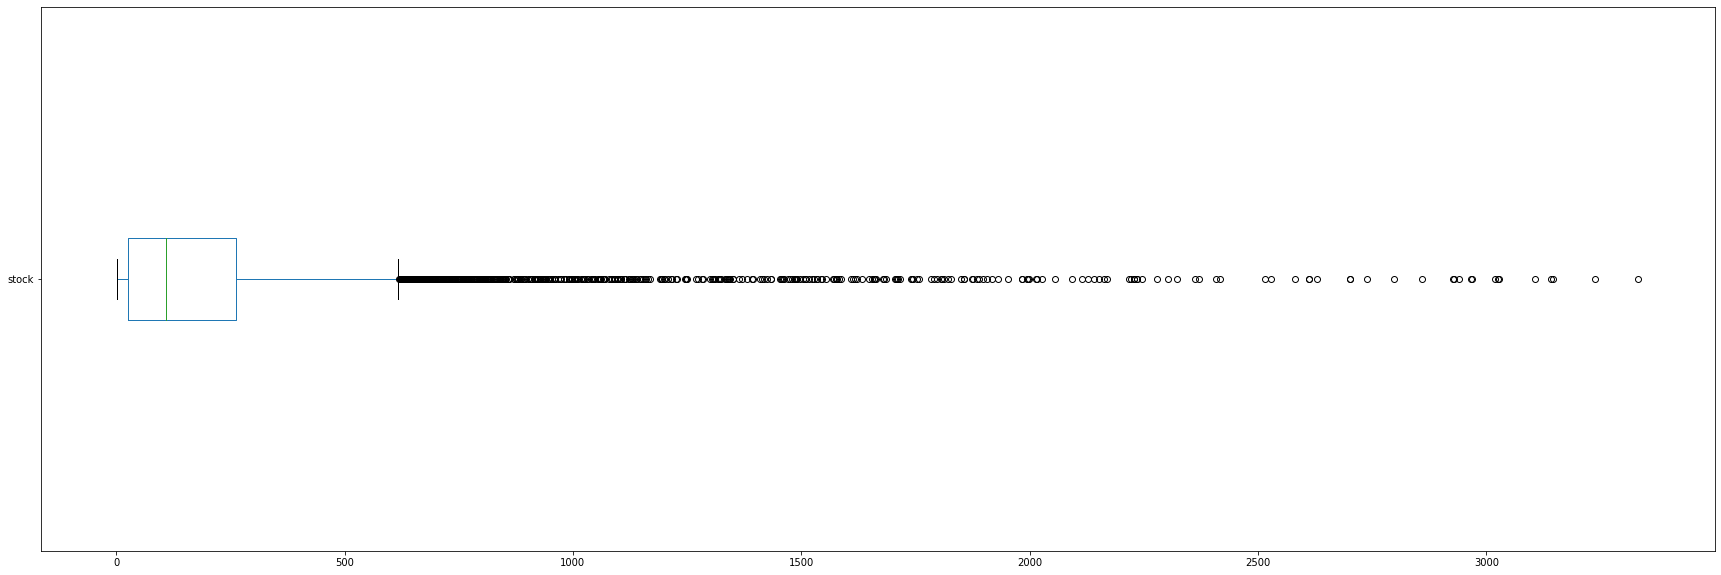

In [14]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

<AxesSubplot:>

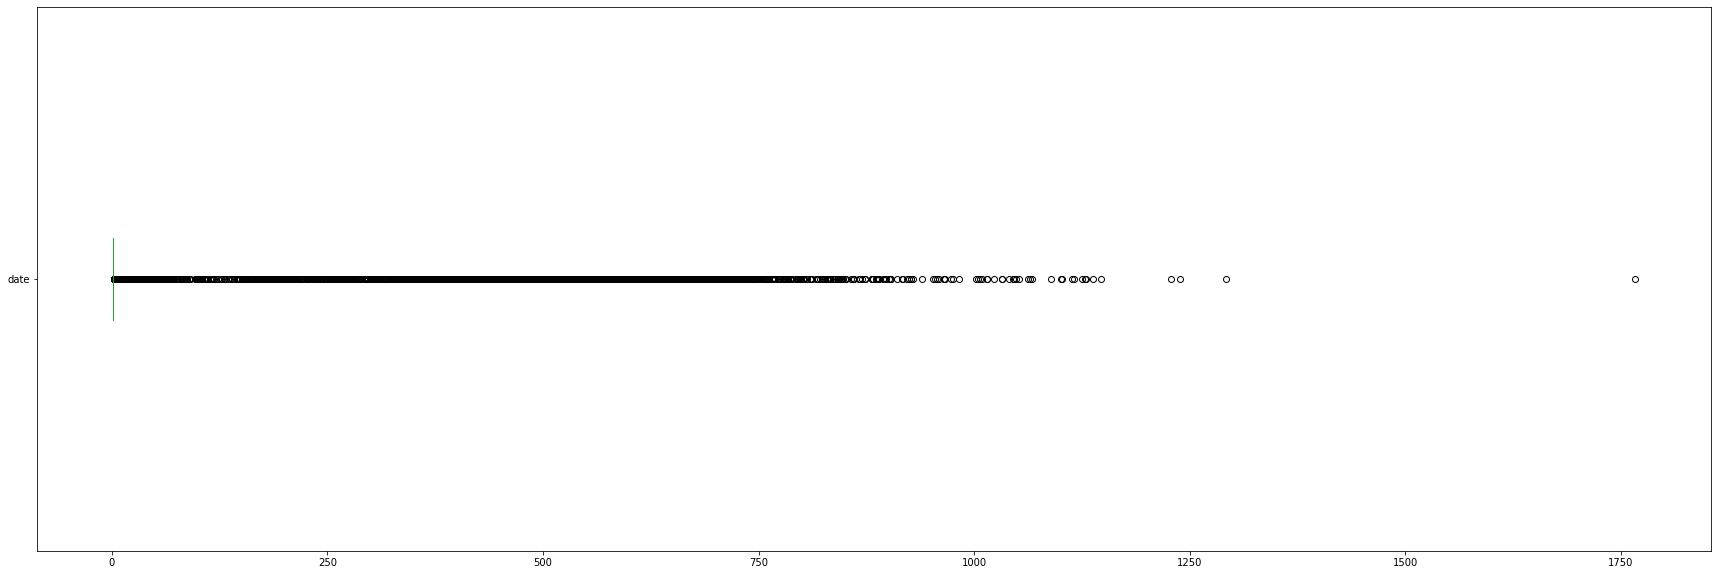

In [15]:
# BocPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

Text(0, 0.5, 'Number of Headlines')

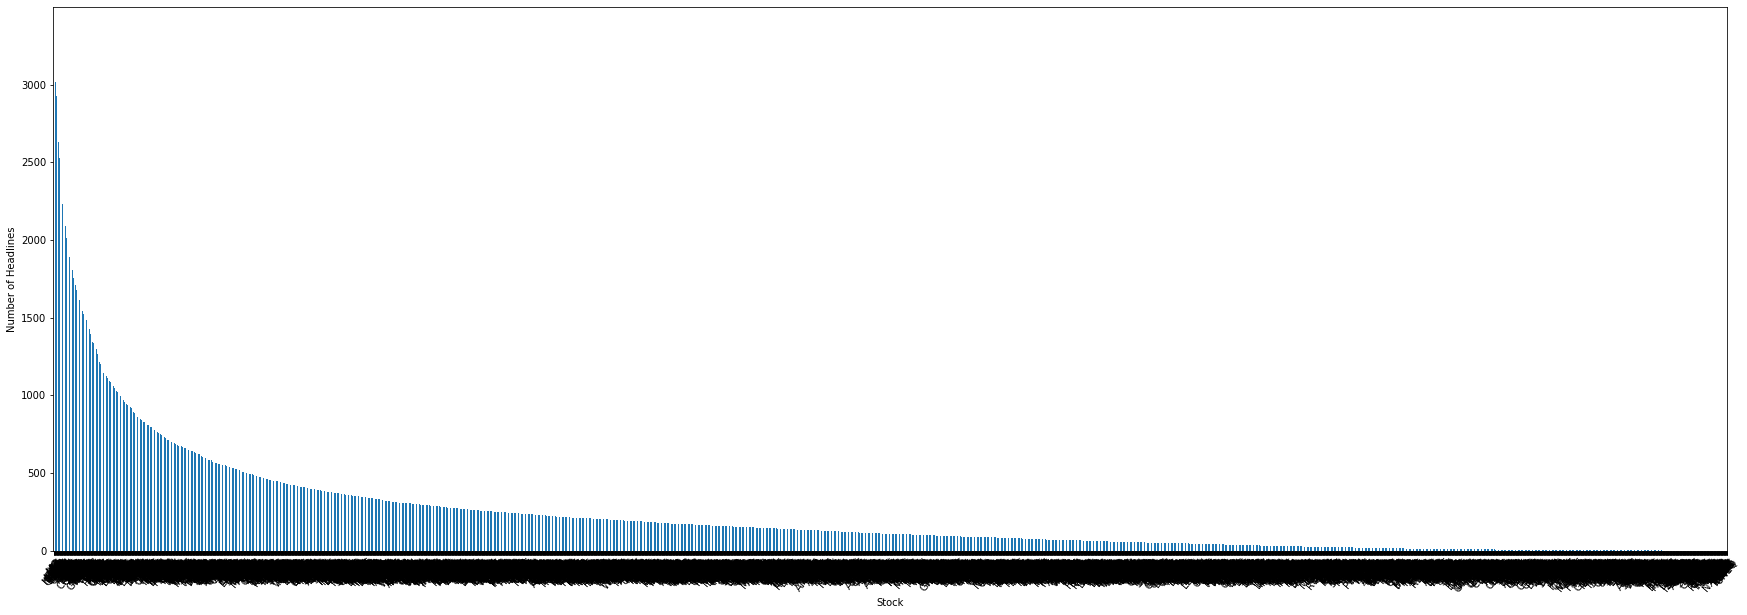

In [16]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")

Text(0, 0.5, 'Number of Headlines')

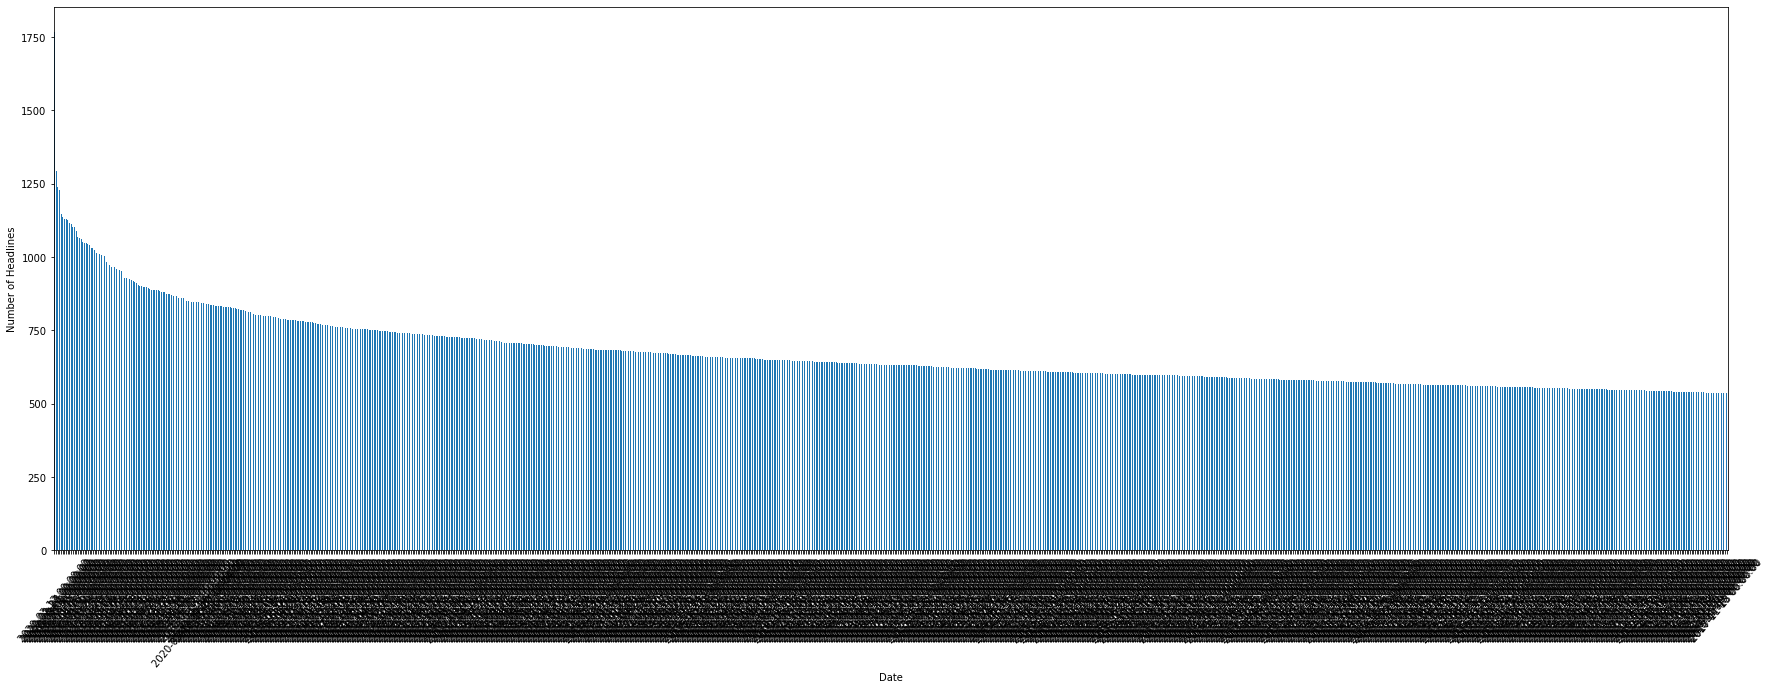

In [35]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

In [5]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

In [6]:
print(date_withYear.columns)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock', 'year'], dtype='object')


Text(0, 0.5, 'Number of Healines')

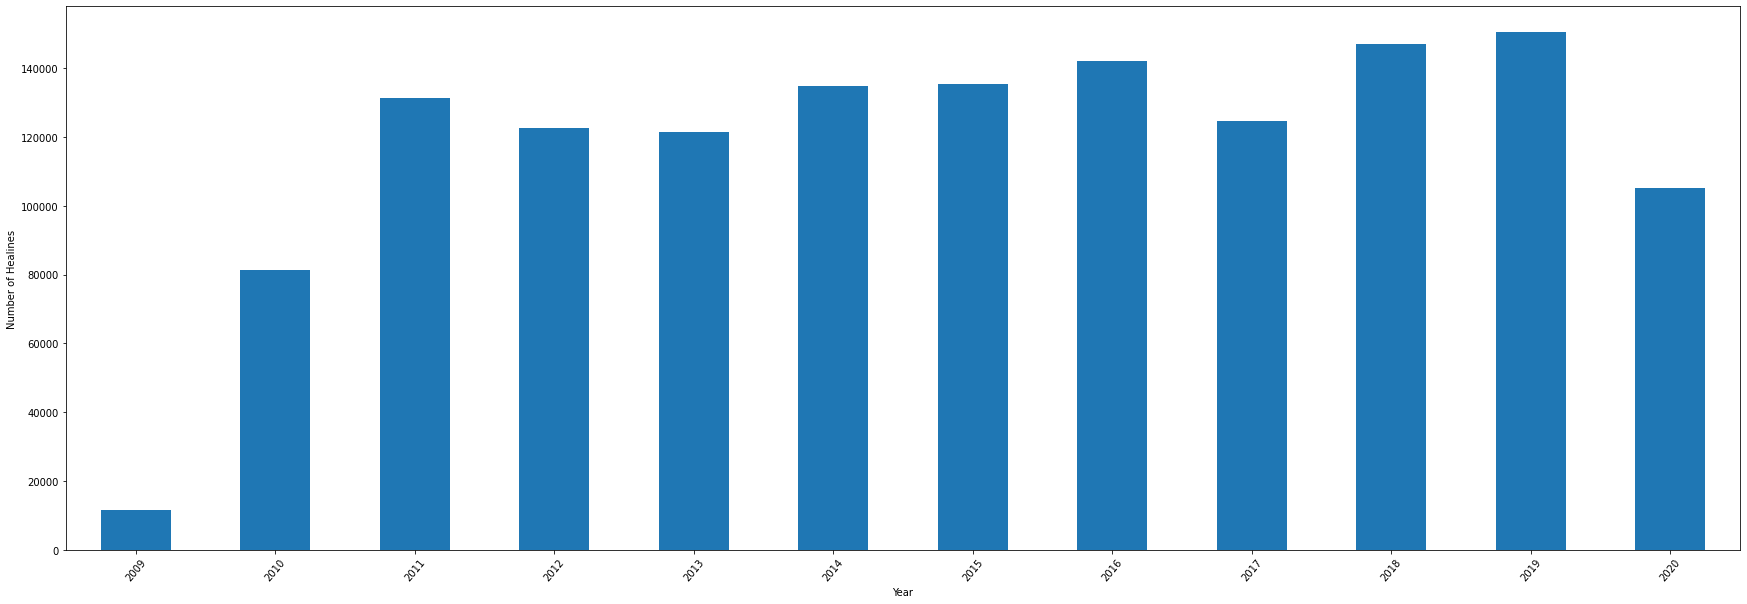

In [9]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [ ]:
# Termdocument Matrix

# all headlines as String in List
docs = []
for headline in data.headline:
    docs.append(headline)
docs = docs[0:1000]

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

#### Wordclouds before Data Cleaning

In [ ]:
# Wordcloud for all Headlines

#combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#!! No Stopword removal
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(max_words=maxWords).generate(text)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud.png")

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WorldCloud for Random Stock: BLDP, Top 50 Words:


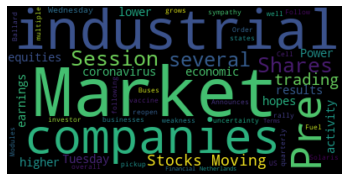

In [14]:
# Wordcloud for one Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

In [ ]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling before Data Cleaning

In [ ]:
# Topic Modelling with topicCount Topics
topicCount = 10

## Necessary Text Cleaning
# Remove punctuation
# data['headline_processed'] = \
# data['headline'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
# data['headline_processed'] = \
# data['headline_processed'].map(lambda x: x.lower())

# stop_words = stopwords.words('english')
# stop_words.extend(['bezinga', 'stock'])

## Necessary Tokenzisation of Sentences to Words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]


headline = data.headline.values.tolist() #use headline_processed instead of headline for a little bit of DataCleaning
headline_words = list(sent_to_words(headline))
# remove stop words
# headline_words = remove_stopwords(headline_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared

### Data Quality

In [18]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))

Anzahl von null Werten im gesamten DataFrame: 0


In [27]:
# count all dates without time
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))

Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341


## Data Preparation

### Clean

### Construct

#### API call to get StockPrices for all stocks that occur more than 10 times
used API : 'https://polygon.io/'
(need timeouts because of max 5 Api calls per Minute)

In [ ]:
# List of Stock Ticker to call
# Stocks that occur more than occ times
occ = 10
stocks = data[data.groupby('stock').stock.transform(len) > occ]
stocks_unique = unique(stocks['stock'])

In [ ]:
# API call with TimeOut (5 per minute)
key = 'grBCBHpUX9BL8Hsy1qWi61pPT60YN3pA'
results = []

for s in stocks_unique:
    #may curse error if intervall to big and API on this price level doesnt like that
    from_ = data['date'].loc[data['stock'] == s].min()
    to = data['date'].loc[data['stock'] == s].max()

    #The API call
    with RESTClient(key) as client:
            resp = client.stocks_equities_aggregates(s, 15, "minute", from_, to, unadjusted=False)
            # save the nessecary attributes of the JSON as List
            for result in resp.results:
                dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                results.append([s, dt, result['o'], result['h'], result['l'], result['c']])
    time.sleep(12)

#save the List-Data as DataFrame
stock_prices = pd.DataFrame(results, columns=['stock', 'time', 'o', 'h', 'l', 'c'])
#save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [ ]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

### Format

## Data Understanding: Visualization after Cleaning

#### Wordclouds after Data Cleaning

#### Topic Modelling after Data Cleaning

## Modeling